In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import r2_score
data = pd.read_csv('data.csv', delimiter=',')

NO2    1397
CO     1382
dtype: int64
74
2832


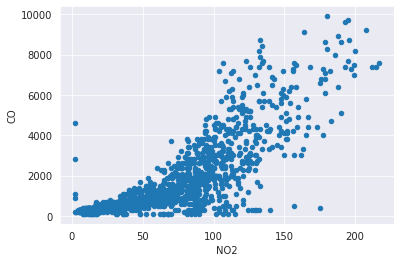

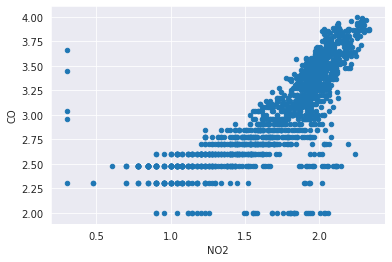

In [41]:
temp = data.loc(axis=1)["NO2", "CO"]
temp.sort_values('NO2', inplace=True)
temp_log = temp.applymap(lambda x: np.log10(x))
temp.plot(x='NO2', y='CO', kind='scatter')
temp_log.plot(x='NO2', y='CO', kind='scatter')
print(temp_log.count())
print(temp[temp.isna().any(axis=1)].size)
print(temp_log.size)

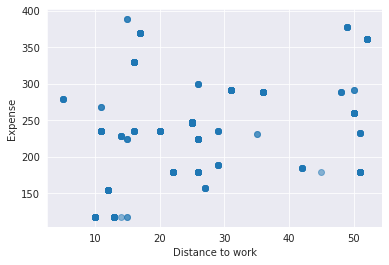

In [20]:
x = data['Distance from Residence to Work'].to_numpy()
x = np.reshape(x, (-1,1))
y = data['Transportation expense'].to_numpy()
ax = sns.regplot(x=x, y=y, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Distance to work', ylabel='Expense');

In [21]:
y.shape

(740,)

In [22]:
x.shape


(740, 1)

In [23]:
from numpy.linalg import inv, det
from numpy import dot

# calculating the coefficient with a god given formula
beta = dot(dot(inv(dot(x.T, x)),x.T),y)
print('estimated beta (Slope of our reg line): ', beta[0])


estimated beta (Slope of our reg line):  6.210711019366148


In [24]:
# calculating the coefficient with numpys least squares impl
beta2 = np.linalg.lstsq(x, y)[0]
print('Estimated second beta: ', beta2[0])

Estimated second beta:  6.210711019366145


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


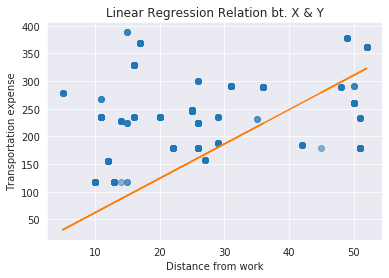

In [25]:
# this is yhat
predictions = x * beta
predictions_without_intercept = predictions
ax = sns.regplot(x=x, y=y, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Distance from work', 
       ylabel='Transportation expense',
       title='Linear Regression Relation bt. X & Y');
plt.plot(x, predictions) # overlay a line plot over a scatter plot 
plt.show()

In [26]:
constant_term = np.ones(len(x))
x = np.c_[constant_term, x]
print(x)

[[ 1. 36.]
 [ 1. 13.]
 [ 1. 51.]
 ...
 [ 1. 14.]
 [ 1. 35.]
 [ 1. 45.]]


In [27]:
beta = np.linalg.lstsq(x, y)[0]
print('Estimated coefficients: ', beta)
print(x)
print('Old shape of coefficients array', beta.shape)
beta = np.reshape(beta,(-1,1))
print('new shape of coefficients array', beta.shape)

Estimated coefficients:  [186.27252316   1.18312276]
[[ 1. 36.]
 [ 1. 13.]
 [ 1. 51.]
 ...
 [ 1. 14.]
 [ 1. 35.]
 [ 1. 45.]]
Old shape of coefficients array (2,)
new shape of coefficients array (2, 1)


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


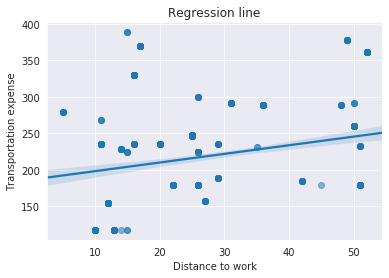

In [44]:
#compute predictions wiht intercept 
#(aka linear regression yhat=beta0+beta1*x)
predictions_with_intercept = dot(x, beta)
ax = sns.regplot(x=x[:,1], y=y, fit_reg=True, scatter_kws={'alpha':0.5})
ax.set(xlabel='Distance to work',
        ylabel='Transportation expense',
      title='Regression line')
#plt.plot(x, predictions_with_intercept)
plt.show()

In [29]:
# r^2 = 1 - (SS_resid / SS_total)
# where SS_resid = np.sum((y-y_pred)**2) -->squared sum of differences between predicted and actual y
# SS_total = np.sum(y - ymean)**2) --> ybar aka squared sum of differences between y and mean of y
# SSR = SS_reg = np.sum(y_pred - ymean)**2) --> explained sum of squares (deviation of predictions from mean of actual values)
ss_total = np.sum((y - np.mean(y)) ** 2 ) 
ssr = np.sum((predictions_with_intercept - np.mean(y)) ** 2)
ss_resid = np.sum((y - predictions_with_intercept) ** 2)
variance = np.var(y, ddof=1)
ss_total_variance = (len(y) - 1) * variance
r_squared = 1 - (ssr / ss_total)
print('SS_total: ', ss_total, ' ', ss_total_variance)
print('SSR: ', ssr)
print('SS_resid: ', ss_resid)
print('Coefficient of determinacy (aka r^2): ',r_squared)


SS_total:  3312641.545945946   3312641.545945946
SSR:  227710.9252118043
SS_resid:  2619860828.6567345
Coefficient of determinacy (aka r^2):  0.9312600164993765


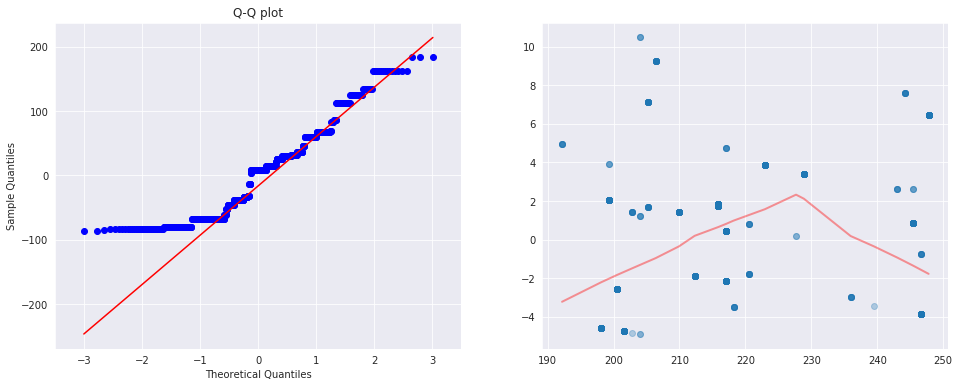

In [30]:
fig, axs = plt.subplots(ncols=2,
                         figsize=(16,6))

predictions = dot(x,beta)
residuals = y - predictions[:,0]
deg_of_freedom = len(y) - x.shape[1]
x_val = x[:,1]

sm.qqplot(residuals, 
          stats.t,
          distargs=(deg_of_freedom,), 
          line='q', 
          ax=axs[0])
axs[0].set_title(label = 'Q-Q plot')
axs[0].set_xlim(-3.5,3.5)

residuals_standard_error = np.sqrt(ssr / deg_of_freedom)
xmean = np.sum(x_val)/len(x_val)
leverage = (1 / len(x_val)) + (x_val - xmean) **2\
                            / np.sum((x_val-xmean) ** 2)
leverage = np.reshape(leverage,(-1,1))

s_resid = residuals_standard_error * np.sqrt(1-leverage)
standardized_residuals = residuals / s_resid[:,0]

sns.regplot(x=predictions[:,0], 
            y=standardized_residuals, 
            ax=axs[1],
            lowess=True, 
            scatter_kws={'alpha':0.3}, 
            line_kws={"color":"r","alpha":0.4,"lw":2})
#plt.plot(np.arange(len(standardized_residuals)), [0]*len(standardized_residuals), 'r-')
#sns.regplot(x=predictions[:,0], 
#            y=standardized_residuals, 
#            ax=axs[1],
#            lowess=True, 
#            scatter_kws={'alpha':0.3}, 
#            line_kws={"color":"r","alpha":0.4,"lw":2})
#plt.plot(np.arange(len(standardized_residuals)), [0]*len(standardized_residuals), 'r-')

